Run command without distractors:
```sh
python scripts/utility_logging_feature_search.py \
    --config-name=comet_sweeps/nonlinear_geoff_ablation_v3/base_config.yaml \
    model.hidden_dim=5120 \
    task.distractor_chance=0 \
    train.total_steps=100_000 \
    train.log_freq=100 \
    comet_ml=True \
    seed=7102025
```

Run command with distractors:
```sh
python scripts/utility_logging_feature_search.py \
    --config-name=comet_sweeps/nonlinear_geoff_ablation_v3/base_config.yaml \
    model.hidden_dim=5120 \
    task.distractor_chance=0.9 \
    train.total_steps=1_000_000 \
    train.log_freq=100 \
    comet_ml=True \
    seed=7102025
```

In [19]:
import array
import sqlite3
from typing import Dict, List, Optional

import matplotlib.pyplot as plt
import numpy as np

from phd.feature_search.scripts.utility_logging_feature_search import FeatureUtilityStats

%matplotlib inline

In [2]:
# Connect to the database
conn = sqlite3.connect('./data/no_distractors_utility_stats.db')
cursor = conn.cursor()

In [3]:
# Get schema of the main table by querying the first row
cursor.execute("SELECT * FROM feature_stats LIMIT 1")
print("Table schema:")
print("\n".join(f"{description[0]} ({description[1]})" for description in cursor.description))

Table schema:
id (None)
creation_step (None)
pruned_step (None)
feature_type (None)
utilities (None)


In [ ]:
cursor.execute("SELECT COUNT(id) FROM feature_stats")
count = cursor.fetchone()[0]
print(f"Total records: {count}")

In [75]:
def get_feature_stats(
    conn: sqlite3.Connection,
    start_step: int,
    end_step: int,
    max_features: Optional[int] = None,
) -> List[FeatureUtilityStats]:
    """Gets feature statistics from the database for features active during the specified time period.

    Args:
        conn: SQLite database connection
        start_step: Starting step to get features from
        end_step: Ending step to get features from 
        max_features: Optional maximum number of features to return. If specified, features
            are randomly sampled.

    Returns:
        List of FeatureUtilityStats objects sorted by creation step, containing feature
        statistics for features that were active during the specified time period.
    """
    cursor = conn.cursor()
    
    if max_features is not None:
        query = """
            SELECT id, creation_step, pruned_step, feature_type, utilities 
            FROM feature_stats 
            WHERE creation_step <= ? AND pruned_step >= ?
            ORDER BY RANDOM()
            LIMIT ?
        """
        cursor.execute(query, (end_step, start_step, max_features))
    else:
        query = """
            SELECT id, creation_step, pruned_step, feature_type, utilities 
            FROM feature_stats 
            WHERE creation_step <= ? AND pruned_step >= ?
        """
        cursor.execute(query, (end_step, start_step))

    # Convert rows to list of dicts with utilities as float arrays
    feature_stats = []
    for row in cursor.fetchall():
        feature_dict = {
            'id': row[0],
            'creation_step': row[1], 
            'pruned_step': row[2],
            'feature_type': row[3],
            # TODO: Change to f for new data
            'utilities': array.array('d', row[4]).tolist() # Convert bytes to float array
        }
        feature_stats.append(FeatureUtilityStats(**feature_dict))

    # Sort by creation step to maintain deterministic ordering
    feature_stats.sort(key=lambda x: x.id)

    print(f"Querried {len(feature_stats)} features active between steps {start_step} and {end_step}")
    return feature_stats


In [76]:
start_features_sample = get_feature_stats(conn, 0, 2000, 1000)
mid_features_sample = get_feature_stats(conn, 50_000, 52_000, 1000)
end_features_sample = get_feature_stats(conn, 98_000, 100_000, 1000)

Querried 1000 features active between steps 0 and 2000
Querried 1000 features active between steps 50000 and 52000
Querried 1000 features active between steps 98000 and 100000


In [ ]:
DEFAULT_COLOR_MAP = {
    'real': 'blue',
    'distractor': 'red',
}

def plot_feature_stats(
    feature_stats: List[FeatureUtilityStats],
    start_step: int,
    end_step: int,
    color_map: Optional[Dict[str, str]] = None,
):
    if color_map is None:
        color_map = DEFAULT_COLOR_MAP
    
    plt.figure(figsize=(10, 5))
    plot_range = end_step - start_step
    for feature in feature_stats:
        feature_start = feature.creation_step
        feature_end = feature.pruned_step
        
        x_start = max(0, feature_start - start_step)
        util_start_idx = max(0, start_step - feature_start)
        
        n_available_steps = min(plot_range, min(end_step, feature_end) - max(start_step, feature_start))
        
        x_end = x_start + n_available_steps
        util_end_idx = util_start_idx + n_available_steps
        
        plot_xs = np.arange(x_start, x_end)
        plot_ys = feature.utilities[util_start_idx:util_end_idx]
        
        if len(plot_xs) == 0:
            continue
        
        # print((start_step, end_step), (feature_start, feature_end), x_start, n_available_steps)
        plt.plot(
            plot_xs + start_step,
            plot_ys,
            color=color_map[feature.feature_type],
            label=feature.feature_type,
            alpha=0.3,
        )
        
        if util_start_idx == 0:
            plt.scatter(
                plot_xs[0] + start_step,
                plot_ys[0],
                color='lightblue',
                alpha=0.5,
                s=13,
                zorder=2
            )
        
        if util_end_idx == len(feature.utilities):
            plt.scatter(
                plot_xs[-1] + start_step,
                plot_ys[-1],
                color='black',
                alpha=0.5,
                s=13,
                zorder=2
            )
    
    plt.xlim(start_step, end_step)
    plt.xlabel('step')
    plt.ylabel('utility')
    plt.ylim(0)
    plt.title(f'Feature utilities between steps {start_step} and {end_step}')
    # plt.legend(color_map.keys())


In [ ]:
plot_feature_stats(start_features_sample, 0, 2000)
plt.show()

plot_feature_stats(mid_features_sample, 50_000, 52_000)
plt.show()

plot_feature_stats(end_features_sample, 98_000, 100_000)
plt.show()

(0, 2000) (0, 127) 0 127
(0, 2000) (0, 2666) 0 2000
(0, 2000) (0, 214) 0 214
(0, 2000) (0, 6211) 0 2000
(0, 2000) (0, 29) 0 29
(0, 2000) (0, 1362) 0 1362
(0, 2000) (0, 297) 0 297
(0, 2000) (0, 244) 0 244
(0, 2000) (0, 2268) 0 2000
(0, 2000) (0, 60616) 0 2000
(0, 2000) (0, 34) 0 34
(0, 2000) (0, 96) 0 96
(0, 2000) (0, 85) 0 85
(0, 2000) (0, 43) 0 43
(0, 2000) (0, 95) 0 95
(0, 2000) (0, 26) 0 26
(0, 2000) (0, 210) 0 210
(0, 2000) (0, 1224) 0 1224
(0, 2000) (0, 314) 0 314
(0, 2000) (0, 94) 0 94
(0, 2000) (0, 2900) 0 2000
(0, 2000) (0, 220) 0 220
(0, 2000) (0, 68) 0 68
(0, 2000) (0, 64) 0 64
(0, 2000) (0, 88) 0 88
(0, 2000) (0, 25264) 0 2000
(0, 2000) (0, 2466) 0 2000
(0, 2000) (0, 149) 0 149
(0, 2000) (0, 28) 0 28
(0, 2000) (0, 33) 0 33
(0, 2000) (0, 298) 0 298
(0, 2000) (0, 70) 0 70
(0, 2000) (0, 84) 0 84
(0, 2000) (0, 33627) 0 2000
(0, 2000) (0, 30759) 0 2000
(0, 2000) (0, 54) 0 54
(0, 2000) (0, 31) 0 31
(0, 2000) (0, 208) 0 208
(0, 2000) (0, 21994) 0 2000
(0, 2000) (0, 424) 0 424
(0, 2

KeyboardInterrupt: 

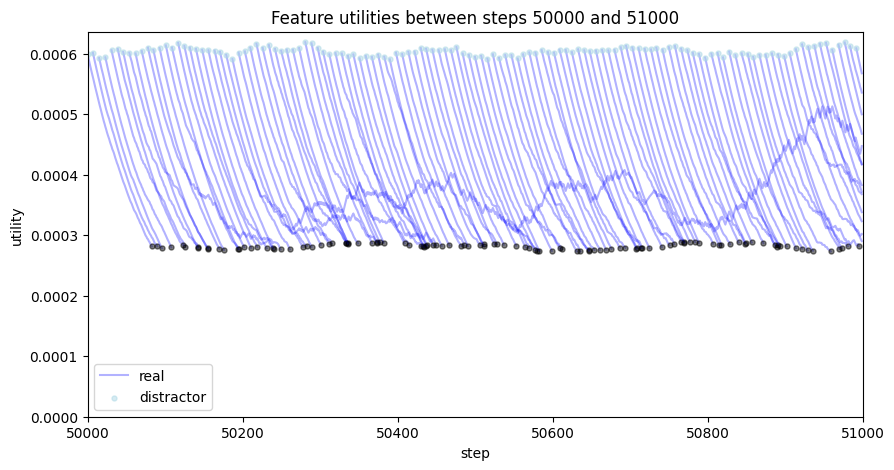

In [68]:
plot_feature_stats(feature_stats[::200], 50000, 51000)